# Imports

In [103]:
import catboost as cb
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import geopandas as gpd

# Configs

In [104]:
INPUT_PATH = 'datasets/'
ARIMA_PATH = 'statics/arima_predict.parquet'
OUTPUT_PATH = 'results/cb_predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-05-15'

FEATURE_LIST = [#'ARIMA_predicts',
                
                #'Bronx',
                #'Brooklyn'	,
                #'EWR'	,
                #'Manhattan'	,
                #'Queens'	,
                #'Staten Island',
                
                #'Previous_week_trip_dist',
                #'Previous_2week_trip_dist',
                #'Previous_day_trip_dist',

                #'Previous_week_passenger_count',
                #'Previous_2week_passenger_count',
                #'Previous_day_passenger_count',

                #'Previous_week_fare_amount',
                #'Previous_day_fare_amount',
                #'Previous_2week_fare_amount',

                'Previous_2week_demand',
                'Previous_week_demand', 

                'Previous_day_demand',
                'Previous_2day_demand',
                'Previous_3day_demand',
                'Previous_4day_demand',
                'Previous_5day_demand',
                'Previous_6day_demand',

                #'Previous_week_extra',
                #'Previous_2week_extra',
                #'Previous_day_extra',
                
                #'Previous_2week_RatecodeID',
                #'Previous_week_RatecodeID',
                #'Previous_day_RatecodeID',

                #'Previous_week_congestion_surcharge',
                #'Previous_2week_congestion_surcharge',
                #'Previous_day_congestion_surcharge',

                #'Day_of_month', 
                'Day_of_week'
                ]

TEST_START_DATE = '2023-04-20'

AUTO_TUNE = False

# Data preparation


## Load Data

In [105]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID', 'trip_distance', 'total_amount', 'passenger_count', 'fare_amount', 'extra', 
                                        'RatecodeID', 'congestion_surcharge', 'tip_amount'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [106]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

In [107]:
print(f'rides dataframe shape : {rides_df.shape}')
rides_df.head()

rides dataframe shape : (14410751, 11)


,tpep_pickup_datetime,PULocationID,trip_distance,total_amount,passenger_count,fare_amount,extra,RatecodeID,congestion_surcharge,tip_amount,PU_date
0,2023-01-01 00:32:10,161,0.97,14.30,1.0,9.3,1.00,1.0,2.5,0.00,2023-01-01
1,2023-01-01 00:55:08,43,1.10,16.90,1.0,7.9,1.00,1.0,2.5,4.00,2023-01-01
2,2023-01-01 00:25:04,48,2.51,34.90,1.0,14.9,1.00,1.0,2.5,15.00,2023-01-01
3,2023-01-01 00:03:48,138,1.90,20.85,0.0,12.1,7.25,1.0,0.0,0.00,2023-01-01
4,2023-01-01 00:10:29,107,1.43,19.68,1.0,11.4,1.00,1.0,2.5,3.28,2023-01-01


In [108]:
arima_df = pd.read_parquet(ARIMA_PATH)

In [109]:
print(f'statics dataframe shape : {arima_df.shape}')
arima_df.head()

statics dataframe shape : (27772, 1)


,0
0,18
1,0
2,1
3,86
4,1


In [110]:
regions_df = gpd.read_file('taxi_zones/taxi_zones.shp')
regions_df = regions_df.rename(columns = {'LocationID' : 'Location'})

In [111]:
regions_df['borough']

0                EWR
1             Queens
2              Bronx
3          Manhattan
4      Staten Island
           ...      
258            Bronx
259           Queens
260        Manhattan
261        Manhattan
262        Manhattan
Name: borough, Length: 263, dtype: object

## Labeling

In [112]:
def labeling(dataset, zones):
    '''dataset_labels_demand = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )'''
    dataset_labels = (
                rides_df.groupby(['PULocationID', 'PU_date'])
                .agg({'trip_distance': 'sum', 'tpep_pickup_datetime': 'count', 'total_amount': 'max', 'passenger_count': 'median' ,'fare_amount': 'sum', 'extra': 'max',
                      'RatecodeID': 'max', 'congestion_surcharge': 'median', 'tip_amount': 'sum'})
                .reset_index()
                .rename(columns={'trip_distance': 'trip_dists', 'tpep_pickup_datetime': 'Demand', 'PULocationID': 'Location', 'PU_date': 'Date'})
)

    locations = pd.DataFrame(dataset_labels['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])

    location_date_df = (
        locations
        .merge(dates, how='cross')
        .sort_values(['Location', 'Date'], ascending=[True, True])
        .reset_index(drop=True)
    )

    labels_df = (
        location_date_df
        .merge(dataset_labels, how='left', on=['Location', 'Date'])
        .merge(zones, how='left', on=['Location'])
        .fillna(value=0)
    )

    return labels_df


In [113]:
labeled_df = labeling(rides_df, regions_df[['borough', 'Location']])

In [114]:
labeled_df = pd.concat([labeled_df, pd.get_dummies(labeled_df["borough"])], axis=1)
labeled_df.drop("borough", axis=1, inplace=True)
labeled_df.drop(0, axis = 1, inplace = True)

In [115]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (35505, 17)


,Location,Date,trip_dists,Demand,total_amount,passenger_count,fare_amount,extra,RatecodeID,congestion_surcharge,tip_amount,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island
0,1,2023-01-01,36.74,40.0,276.00,2.0,3441.62,0.0,5.0,0.0,393.43,0,0,1,0,0,0
1,1,2023-01-02,45.33,31.0,279.50,1.0,2699.66,0.0,5.0,0.0,363.76,0,0,1,0,0,0
2,1,2023-01-03,0.54,27.0,351.00,1.0,2233.76,0.0,5.0,0.0,296.50,0,0,1,0,0,0
3,1,2023-01-04,2.60,7.0,204.69,2.0,751.73,0.0,5.0,0.0,194.64,0,0,1,0,0,0
4,1,2023-01-05,68.41,15.0,213.00,2.0,1340.66,2.5,5.0,0.0,200.13,0,0,1,0,0,0


In [116]:
labeled_df.to_parquet('labels.parquet')

## Add Feature

In [117]:
def feature_engineering(dataset, statics_df):
    dataset['Previous_day_demand'] = dataset.groupby(['Location'])['Demand'].shift(1)
    dataset['Previous_2day_demand'] = dataset.groupby(['Location'])['Demand'].shift(2)
    dataset['Previous_3day_demand'] = dataset.groupby(['Location'])['Demand'].shift(3)
    dataset['Previous_4day_demand'] = dataset.groupby(['Location'])['Demand'].shift(4)
    dataset['Previous_5day_demand'] = dataset.groupby(['Location'])['Demand'].shift(5)
    dataset['Previous_6day_demand'] = dataset.groupby(['Location'])['Demand'].shift(6)
    dataset['Previous_week_demand'] = dataset.groupby(['Location'])['Demand'].shift(7)
    dataset['Previous_2week_demand'] = dataset.groupby(['Location'])['Demand'].shift(14)

    dataset['Previous_week_passenger_count'] = dataset.groupby(['Location'])['passenger_count'].shift(7)
    dataset['Previous_2week_passenger_count'] = dataset.groupby(['Location'])['passenger_count'].shift(14)
    dataset['Previous_day_passenger_count'] = dataset.groupby(['Location'])['passenger_count'].shift(1)

    dataset['Previous_week_trip_dist'] = dataset.groupby(['Location'])['trip_dists'].shift(7)
    dataset['Previous_2week_trip_dist'] = dataset.groupby(['Location'])['trip_dists'].shift(14)
    dataset['Previous_day_trip_dist'] = dataset.groupby(['Location'])['trip_dists'].shift(1)

    dataset['Previous_week_tip_amount'] = dataset.groupby(['Location'])['tip_amount'].shift(7)
    dataset['Previous_2week_tip_amount'] = dataset.groupby(['Location'])['tip_amount'].shift(14)
    dataset['Previous_day_tip_amount'] = dataset.groupby(['Location'])['tip_amount'].shift(1)

    dataset['Previous_week_fare_amount'] = dataset.groupby(['Location'])['fare_amount'].shift(7)
    dataset['Previous_2week_fare_amount'] = dataset.groupby(['Location'])['fare_amount'].shift(14)
    dataset['Previous_day_fare_amount'] = dataset.groupby(['Location'])['fare_amount'].shift(1)

    dataset['Previous_week_extra'] = dataset.groupby(['Location'])['extra'].shift(7)
    dataset['Previous_2week_extra'] = dataset.groupby(['Location'])['extra'].shift(14)
    dataset['Previous_day_extra'] = dataset.groupby(['Location'])['extra'].shift(1)
    
    dataset['Previous_week_RatecodeID'] = dataset.groupby(['Location'])['RatecodeID'].shift(7)
    dataset['Previous_2week_RatecodeID'] = dataset.groupby(['Location'])['RatecodeID'].shift(14)
    dataset['Previous_day_RatecodeID'] = dataset.groupby(['Location'])['RatecodeID'].shift(1)

    dataset['Previous_week_congestion_surcharge'] = dataset.groupby(['Location'])['congestion_surcharge'].shift(7)
    dataset['Previous_2week_congestion_surcharge'] = dataset.groupby(['Location'])['congestion_surcharge'].shift(14)
    dataset['Previous_day_congestion_surcharge'] = dataset.groupby(['Location'])['congestion_surcharge'].shift(1)


    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek   
    dataset['Day_of_month'] = dataset['Date'].dt.day

    dataset = dataset.sort_values(by = ['Date', 'Location'])
    dataset['ARIMA_predicts'] = None
    start_index = len(dataset) - len(statics_df)
    end_index = len(dataset)
    dataset.iloc[start_index:end_index, dataset.columns.get_loc('ARIMA_predicts')] = statics_df
    dataset['ARIMA_predicts'] = dataset['ARIMA_predicts'].astype('float')
    dataset = dataset.sort_values(by = ['Location', 'Date'])
    
    return dataset

In [118]:
features_df = feature_engineering(labeled_df, arima_df)
features_df.dropna(inplace = True)

In [119]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (27772, 49)


,Location,Date,trip_dists,Demand,total_amount,passenger_count,fare_amount,extra,RatecodeID,congestion_surcharge,...,Previous_day_extra,Previous_week_RatecodeID,Previous_2week_RatecodeID,Previous_day_RatecodeID,Previous_week_congestion_surcharge,Previous_2week_congestion_surcharge,Previous_day_congestion_surcharge,Day_of_week,Day_of_month,ARIMA_predicts
30,1,2023-01-31,16.70,8.0,145.20,1.0,679.45,0.0,5.0,0.0,...,1.0,5.0,5.0,5.0,0.0,0.0,0.0,1,31,3253.0
31,1,2023-02-01,15.80,9.0,190.25,2.0,1080.30,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,2,1,2562.0
32,1,2023-02-02,0.05,18.0,181.20,1.5,1591.75,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,3,2,2338.0
33,1,2023-02-03,7.25,10.0,251.25,1.0,1254.00,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,4,3,2156.0
34,1,2023-02-04,0.18,12.0,157.80,1.0,828.00,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,5,4,3.0


In [120]:
pca = PCA()
pca.fit(features_df[FEATURE_LIST])


cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum, len(FEATURE_LIST), pca.feature_names_in_

(array([0.95994369, 0.97712499, 0.99097558, 0.99447747, 0.99739927,
        0.99844108, 0.99927269, 0.99999953, 1.        ]),
 9,
 array(['Previous_2week_demand', 'Previous_week_demand',
        'Previous_day_demand', 'Previous_2day_demand',
        'Previous_3day_demand', 'Previous_4day_demand',
        'Previous_5day_demand', 'Previous_6day_demand', 'Day_of_week'],
       dtype=object))

## Split Train and Test Data

In [121]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [122]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)
'''pca = PCA(n_components = 5)
xtrain = pca.fit_transform(train_df[FEATURE_LIST])

pca = PCA(n_components = 5)
xtest = pca.fit_transform(test_df[FEATURE_LIST])

pca.fit(features_df[FEATURE_LIST])'''

'pca = PCA(n_components = 5)\nxtrain = pca.fit_transform(train_df[FEATURE_LIST])\n\npca = PCA(n_components = 5)\nxtest = pca.fit_transform(test_df[FEATURE_LIST])\n\npca.fit(features_df[FEATURE_LIST])'

In [123]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (20934, 49)


,Location,Date,trip_dists,Demand,total_amount,passenger_count,fare_amount,extra,RatecodeID,congestion_surcharge,...,Previous_day_extra,Previous_week_RatecodeID,Previous_2week_RatecodeID,Previous_day_RatecodeID,Previous_week_congestion_surcharge,Previous_2week_congestion_surcharge,Previous_day_congestion_surcharge,Day_of_week,Day_of_month,ARIMA_predicts
30,1,2023-01-31,16.70,8.0,145.20,1.0,679.45,0.0,5.0,0.0,...,1.0,5.0,5.0,5.0,0.0,0.0,0.0,1,31,3253.0
31,1,2023-02-01,15.80,9.0,190.25,2.0,1080.30,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,2,1,2562.0
32,1,2023-02-02,0.05,18.0,181.20,1.5,1591.75,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,3,2,2338.0
33,1,2023-02-03,7.25,10.0,251.25,1.0,1254.00,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,4,3,2156.0
34,1,2023-02-04,0.18,12.0,157.80,1.0,828.00,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,5,4,3.0


In [124]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (6838, 49)


,Location,Date,trip_dists,Demand,total_amount,passenger_count,fare_amount,extra,RatecodeID,congestion_surcharge,...,Previous_day_extra,Previous_week_RatecodeID,Previous_2week_RatecodeID,Previous_day_RatecodeID,Previous_week_congestion_surcharge,Previous_2week_congestion_surcharge,Previous_day_congestion_surcharge,Day_of_week,Day_of_month,ARIMA_predicts
109,1,2023-04-20,21.26,15.0,157.50,1.0,1538.01,0.0,5.0,0.0,...,2.5,5.0,5.0,5.0,0.0,0.0,0.0,3,20,0.0
110,1,2023-04-21,0.00,15.0,177.75,1.0,1440.13,2.5,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,4,21,3.0
111,1,2023-04-22,31.29,16.0,251.00,1.0,2291.92,1.0,5.0,0.0,...,2.5,5.0,5.0,5.0,0.0,0.0,0.0,5,22,6.0
112,1,2023-04-23,16.34,24.0,174.90,1.0,2016.63,0.0,5.0,0.0,...,1.0,5.0,5.0,5.0,0.0,0.0,0.0,6,23,13.0
113,1,2023-04-24,0.11,10.0,147.60,2.0,942.00,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,0,24,66.0


# Model Training

## **CatBoost Regressor**

### Model Tuning

In [125]:
def grid_search(model, test_parameters, train_data, feature_list, cv = None):
    gs = GridSearchCV(
        estimator = model, 
        param_grid = test_parameters, 
        scoring = 'neg_root_mean_squared_error', 
        cv = cv, 
        n_jobs = -1
        )
    
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [126]:
if AUTO_TUNE:
    params_test= {
    'depth': [4, 5],
    'learning_rate': [0.1, 0.7, 0.05, 0.03],
    'l2_leaf_reg': [6, 7, 8, 9, 10],
    'iterations': [150, 200, 250, 300],
    'early_stopping_rounds': [10, 20, 30]
}

    best_params, best_score = grid_search(
        model = cb.CatBoostRegressor(), 
        test_parameters = params_test,
        train_data = train_df, 
        feature_list = FEATURE_LIST, 
        cv = 3
        )
    
    print(best_params, best_score)
else:
    best_params = {'depth': 6, 
                   'early_stopping_rounds': 10, 
                   'iterations': 300, 
                   'l2_leaf_reg': 5, 
                   'learning_rate': 0.05}
    '''{'depth': 6, 
                   'early_stopping_rounds': 10, 
                   'iterations': 300, 
                   'l2_leaf_reg': 8, 
                   'learning_rate': 0.03}'''

### Prediction

In [127]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])
    '''model.fit(train_data[feature_list], train_data['Demand'], 
            eval_set=[(test_data[feature_list], test_data['Demand'])], 
            early_stopping_rounds=100)
    print(np.min(model.evals_result()['validation_0']['rmse']))'''
    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [128]:
model = cb.CatBoostRegressor(**best_params)
train_prediction_df, test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

0:	learn: 958.6821461	total: 12.5ms	remaining: 3.73s
1:	learn: 914.2504269	total: 16.9ms	remaining: 2.52s
2:	learn: 872.5734217	total: 20.4ms	remaining: 2.02s
3:	learn: 831.4562988	total: 24.6ms	remaining: 1.82s
4:	learn: 792.3079180	total: 30.1ms	remaining: 1.78s
5:	learn: 755.6978528	total: 33.5ms	remaining: 1.64s
6:	learn: 720.1656181	total: 38.5ms	remaining: 1.61s
7:	learn: 687.3772442	total: 42.5ms	remaining: 1.55s
8:	learn: 655.3785960	total: 46.2ms	remaining: 1.49s
9:	learn: 624.8389649	total: 51.1ms	remaining: 1.48s
10:	learn: 596.0066530	total: 54.8ms	remaining: 1.44s
11:	learn: 568.5150344	total: 58.9ms	remaining: 1.41s
12:	learn: 542.5053862	total: 65.3ms	remaining: 1.44s
13:	learn: 517.8221345	total: 71.6ms	remaining: 1.46s
14:	learn: 494.9529109	total: 76.2ms	remaining: 1.45s
15:	learn: 473.0337135	total: 87ms	remaining: 1.54s
16:	learn: 451.5418826	total: 91.7ms	remaining: 1.53s
17:	learn: 431.4723988	total: 96.2ms	remaining: 1.51s
18:	learn: 412.1896498	total: 100ms	rema

98:	learn: 96.6267772	total: 473ms	remaining: 961ms
99:	learn: 96.4650427	total: 480ms	remaining: 960ms
100:	learn: 96.3058976	total: 485ms	remaining: 955ms
101:	learn: 96.0843046	total: 490ms	remaining: 951ms
102:	learn: 95.8698349	total: 496ms	remaining: 948ms
103:	learn: 95.7016983	total: 502ms	remaining: 946ms
104:	learn: 95.5800150	total: 517ms	remaining: 961ms
105:	learn: 95.3966517	total: 524ms	remaining: 958ms
106:	learn: 95.2093535	total: 530ms	remaining: 956ms
107:	learn: 95.0849296	total: 536ms	remaining: 953ms
108:	learn: 94.8944098	total: 541ms	remaining: 948ms
109:	learn: 94.7738313	total: 545ms	remaining: 942ms
110:	learn: 94.5831914	total: 552ms	remaining: 939ms
111:	learn: 94.4539353	total: 562ms	remaining: 943ms
112:	learn: 94.3035427	total: 570ms	remaining: 943ms
113:	learn: 94.1665265	total: 578ms	remaining: 943ms
114:	learn: 94.0197393	total: 592ms	remaining: 952ms
115:	learn: 93.8550701	total: 612ms	remaining: 970ms
116:	learn: 93.6773925	total: 620ms	remaining: 9

### Visualization

In [129]:
def add_day_of_year(data):
    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [130]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):

    train_data = add_day_of_year(train_data)
    test_data = add_day_of_year(test_data)

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

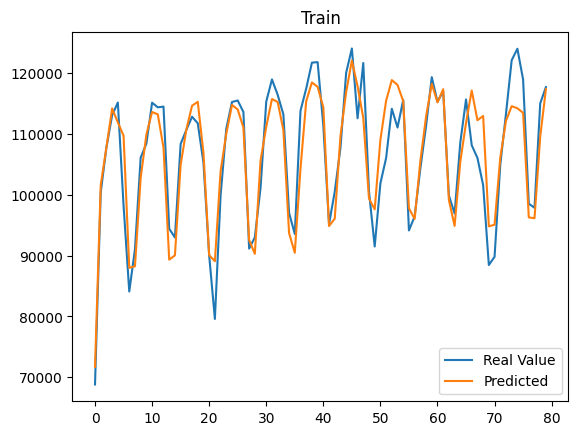

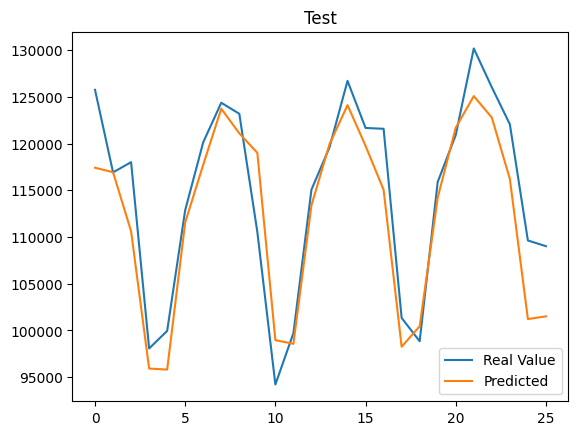

In [131]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [132]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [133]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    smape = np.mean(numerator / denominator)
    return smape * 100

In [134]:
def evaluation(model_name, train_df, test_df, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_df['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_df['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_df['Demand'], train_prediction_df)
    evaluate(smape, 'smape', train_df['Demand'], train_prediction_df)

    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_df['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_df['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_df['Demand'], test_prediction_df)
    evaluate(smape, 'smape', test_df['Demand'], test_prediction_df)


In [135]:
evaluation('XGB', train_df, test_df, train_prediction_df, test_prediction_df)

XGB train scores:
MAE : 28.680348190915865
MSE : 6327.035487220942
MAPE : 2105342834032985.5
smape : 31.818571462093548
XGB test scores:
MAE : 29.78709574109826
MSE : 7728.939487973165
MAPE : 2013547205573267.0
smape : 31.395100986223113


### Feature Importance

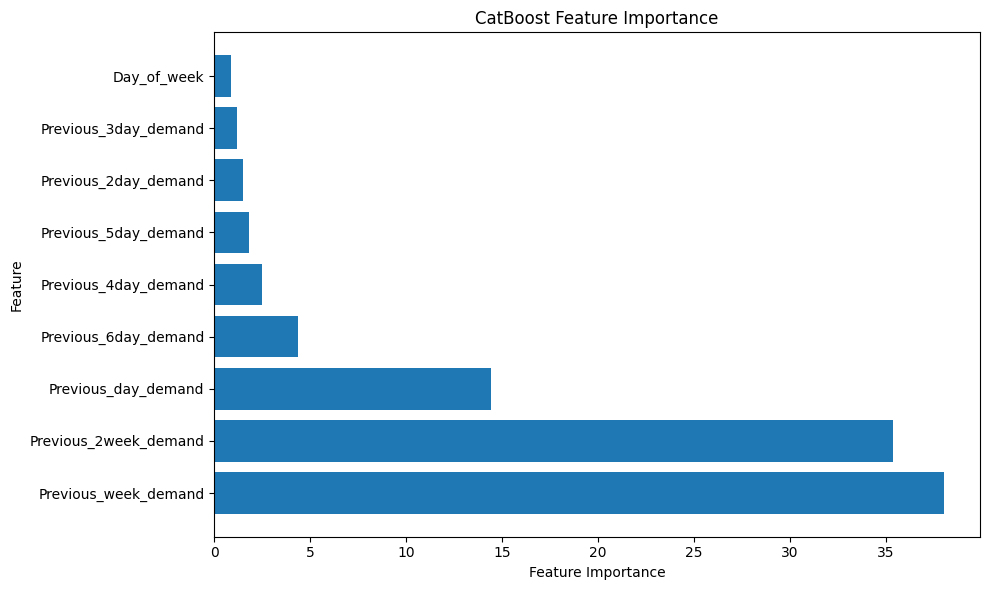

In [136]:
feature_importance = model.get_feature_importance()

# Create a list of feature names
feature_names = FEATURE_LIST

# Sort feature importance and feature names in descending order
sorted_indices = feature_importance.argsort()[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.yticks(range(len(sorted_feature_importance)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()

# File Saving

In [137]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [138]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [139]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [140]:
print(f'labeled prediction dataframe shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

labeled prediction dataframe shape : (6838, 3)


,Location,Date,Predicted_demand
0,1,2023-04-20,13.285469
1,1,2023-04-21,12.960900
2,1,2023-04-22,14.726579
3,1,2023-04-23,9.744867
4,1,2023-04-24,9.677623


In [141]:
save_predictions(labeled_prediction_df, OUTPUT_PATH)